# Devoir 1

## Initialisations
### Importation des modules

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import sklearn.metrics as metrics
import scipy.fftpack as fftpack
import scipy

import matplotlib.pyplot as plt
import matplotlib.image as img 
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


### Fonction Utile

In [2]:
def printImage(x, width=28, height=28):
    plt.imshow(x.reshape((height, width)), cmap='gray')


## Definition des listes de données mnist


In [3]:
f = lambda x : 1 if x > 127 else 0
normalize = np.vectorize(f)

mnist_train = np.loadtxt("mnist_train.csv", delimiter=",", skiprows=1)
mnist_train[:, 1:] = normalize(mnist_train[:,1:])

mnist_test = np.loadtxt("mnist_test.csv", delimiter=",", skiprows=1)
mnist_test[:, 1:] = normalize(mnist_test[:,1:])



In [4]:
n_train_data = mnist_train.shape[0]

n_test_data = mnist_test.shape[0]

ndim = mnist_train.shape[1] - 1
img_dim = int(ndim ** (1./2.))

## Prétraitement
Prétraitement avec Discret cosinus transform

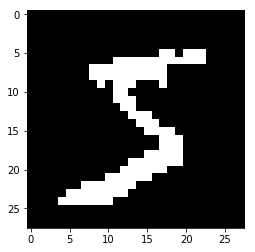

In [115]:
def complex_dist(x, y):
    return np.sum(np.abs(x + y), axis=-1)


def weighted_dist(x, y, sigma):
    result = 0
    for i in range(len(x)):
        for j in range(len(y)):
            result += np.abs(x[i] - y[j]) * sigma[i, j]
    return result
            
def matrix_dist(x, y):
    return np.sum(np.abs(x.reshape((28, 28)) - y.reshape((28, 28))))


#donne d'entrainement

#print(sum_mnist2)
mnist_train_mod = mnist_train

#donne de test
mnist_test_mod = mnist_test

#image de la premiere valeur (5)
plt.figure()
printImage(mnist_train[0, 1:])
#image dans la base des frequance apres la transfromer de fourier
#plt.figure()
#printImage(mnist_train_fft[0, 1:])




## Traitement par centroid

Pour ce traitement on commence par calculé le centroid de limage en calculant la moyenne des coordoné x, y des pixels noires de l'image. Ensuit on subdivise l'image n fois. cela donne $2^n$ sous image. pour chacune de ces sous images on calcul le centroid de celle ci de la même manière que pour l'image complète. Ensuit on garde dans un vecteur les distances entre les cenroides d'une sous-image avec le centroide de l'image complète. ceci nous donne un vecteur de dimension $2^n$. n dans ce model est un hyperparamètre.

L'idée derrière cette methode est que si on regarde pixel par pixel deux images d'un même chiffre, on obtient beaucoup de différence. En prenant des sous-sections plus large, on élimine les petites variations de pixels et on garde une forme plus globale. Le fait de prendre la différence entre les centroids des sous-sections et du centroid globale élimine les effet des translation 

Par la suite la distance euclidienne sera utilisé pour comparer les nouveaux vecteurs obtenues

[[[ 14.27027027  13.5045045 ]
  [  8.27027027   1.5045045 ]
  [  8.57027027   3.8954955 ]
  [  8.77027027   7.9954955 ]]

 [[  7.27027027  13.5045045 ]
  [  5.27027027   2.33783784]
  [  5.63390663   1.95004095]
  [  7.27027027   7.4954955 ]]

 [[  0.27027027  13.5045045 ]
  [  5.3963964    0.83783784]
  [  3.0511583    3.10263835]
  [  0.27027027   7.4954955 ]]

 [[  9.32972973   8.3045045 ]
  [  8.20592021   3.64736165]
  [  6.72972973   0.9954955 ]
  [  6.72972973   7.4954955 ]]]


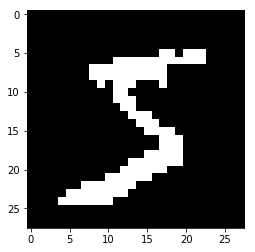

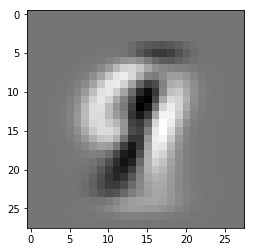

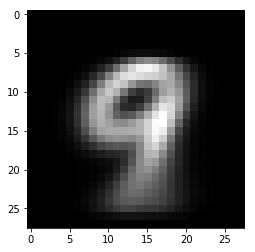

In [5]:
pca = PCA() # objet pca
#donné restructuré par chiffre
mnist_class = [mnist_train[mnist_train[:,0] == i, 1:] for i in range(10)]

# liste des moyenne de chaque chiffre
mnist_class_mean = np.array([np.mean(datas, axis=0) for datas in mnist_class])

#teste de pca sur les 9
mnist9_pca = pca.fit_transform(np.append(mnist_class[9],mnist_class[1], axis=0))


###################################################################################################################
#retourne le centroid des point noire d'une image en coordonné (vertical, horizontale)
def get_center(x):
    dx, dy = x.shape[0], x.shape[1]
    vect = np.zeros((dx*dy, 2))
    k = 0
    result = np.zeros((2))
    for i in range(dy):
        for j in range(dx):
            if x[i, j] == 1:
                result += np.array([i, j])
                k += 1
                
    return result / k if k > 0 else 0

#print(get_center(mnist_train[1, 1:]))

#calcul la distance des centroid des différentes 
#sous-section de l'image avec le centroid de limage total, 
#le nombre de separation doite etre un diviseur de 28
def grid(x, n=2):
    ndim = 28
    img = x.reshape((28, 28))
    delta = ndim // n
    center = get_center(img)
    centroids = np.zeros((n, n, 2))
    for i in range(n):
        for j in range(n):
            i_square = i*delta
            j_square = j*delta 
            centroids[i, j] = np.array([i_square, j_square]) + get_center(img[i_square:(i+1)*delta, j_square:(j+1)*delta])
    return np.abs(centroids - center) #distance de manhattan

#applique grid a une liste de donné
def to_grids(x, n_sub=2):
    n_data = x.shape[0]
    n_sub_dim = n_sub**2*2
    result = np.zeros((n_data, n_sub_dim))
    for i in range(n_data):
        result[i] = grid(x[i], n_sub).reshape(n_sub_dim) #les donné sont transformer en vecteur
        
    return result

print(grid(mnist_train[0 ,1:], 4))
    
printImage(mnist_train[0,1:])
plt.figure()
printImage(pca.components_[0])
plt.figure()
printImage(mnist_class_mean[9])

## Algorithmes

In [7]:
n_sub_div = 4 #nombre de subdivision d'image (hyperparamètre)
n_sub_dim = n_sub_div**2*2 #dimension du vecteur résultant en fonction du nombre de subdivision

#transformation des donné mnist (peu prendre un certain temps)
n_example = 5000
#entrainement
mnist_train_mod = np.zeros((n_example, n_sub_dim + 1))
mnist_test_mod = np.zeros((n_example, n_sub_dim + 1))
#test
mnist_train_mod[:, 1:] = to_grids(mnist_train[:n_example, 1:], n_sub_div)
mnist_test_mod[:, 1:] = to_grids(mnist_test[:n_example, 1:], n_sub_div)

print(mnist_train_mod[0])

[  0.          14.27027027  13.5045045    8.27027027   1.5045045
   8.57027027   3.8954955    8.77027027   7.9954955    7.27027027
  13.5045045    5.27027027   2.33783784   5.63390663   1.95004095
   7.27027027   7.4954955    0.27027027  13.5045045    5.3963964
   0.83783784   3.0511583    3.10263835   0.27027027   7.4954955
   9.32972973   8.3045045    8.20592021   3.64736165   6.72972973
   0.9954955    6.72972973   7.4954955 ]


### K-medoid

[  40 4146  526 2267 4184 2280  928 4743 1409  781]
[2699, 4118, 4653, 1237, 2207, 2796, 4363, 4897, 215, 745]
[2572, 1850, 2298, 2331, 4184, 4371, 3463, 820, 4121, 639]


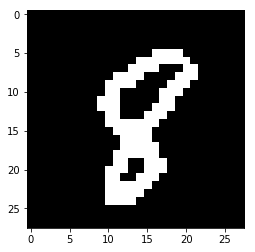

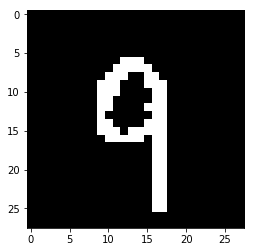

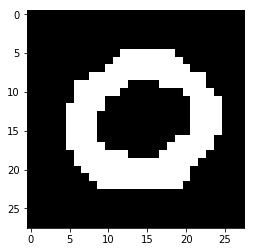

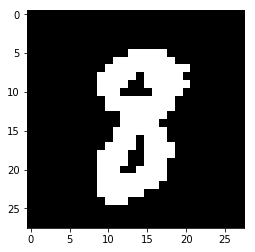

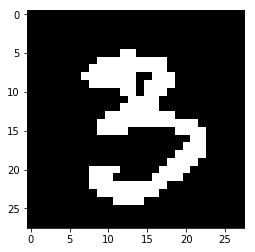

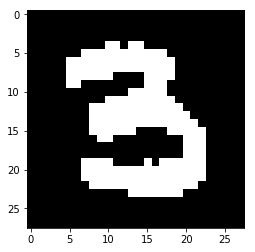

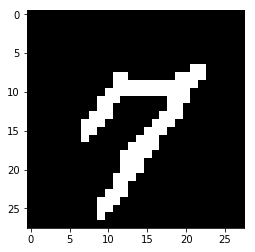

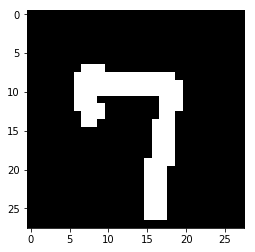

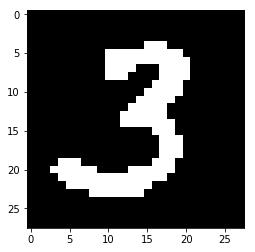

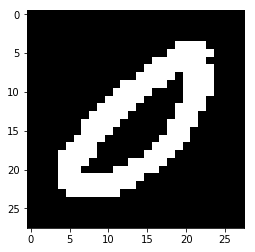

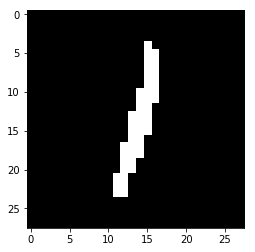

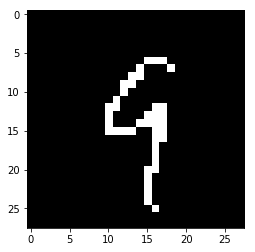

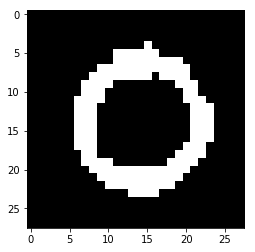

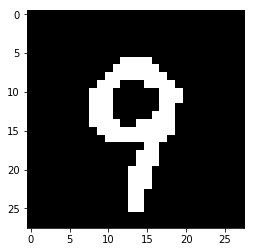

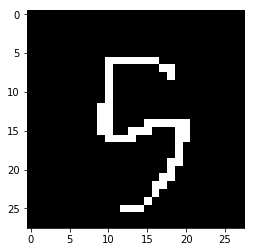

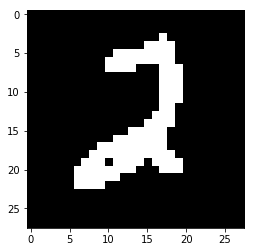

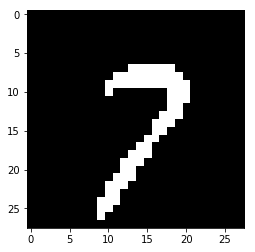

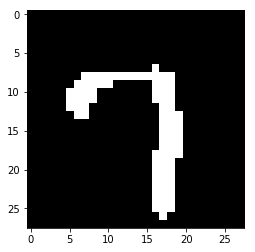

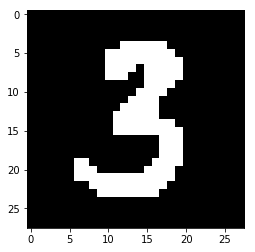

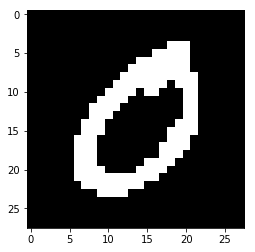

In [8]:
n_data = 5000 # nombre de donne

mnist_mod_data = mnist_train_mod[:n_data, 1:]
mnist_data = mnist_train[:n_data, 1:]
#mnist_mod_data = mnist_data

d_mod = metrics.pairwise_distances(mnist_mod_data, mnist_mod_data)

d_euc = metrics.pairwise.euclidean_distances(mnist_data, mnist_data)


#print(d_mod)

np.random.seed(25255)

# initialize les medoids
initial_medoids = np.zeros((10), dtype="int32")
for i in range(10):
    n = np.random.randint(n_data)
    while n in initial_medoids:
        n = np.random.randint(n_data)
        
    initial_medoids[i] = n

print("Medoid intitaux: " + str(initial_medoids))

#print(d_mod.shape)

#cas fourier
k_mod = kmedoids(d_mod, initial_medoids, data_type='distance_matrix')
k_mod.process()
medoids = k_mod.get_medoids()

print("Image des medoids obtenus par les donné des distance des centroid dans la base original")
for cent in mnist_data[medoids] :    
    plt.figure()
    printImage(cent)

# cas eucliden
k_euc = kmedoids(d_euc, initial_medoids, data_type='distance_matrix')
k_euc.process()
medoids = k_euc.get_medoids()

print("Image des medoids obtenue par la distance euclidienne entre le donnés")
for cent in mnist_data[medoids] :
    plt.figure()
    printImage(cent)
    
    

#### Evaluation

In [9]:
def prediction(clusters, datasize):
    predict = np.zeros((datasize), dtype="int32")
    for i in range(len(clusters)):
        predict[clusters[i]] = i
    return predict

predictions_mod = prediction(k_mod.get_clusters(), mnist_mod_data.shape[0])
#print(predictions_fft)
print("Score silhouette de la distance centroid: " + str(metrics.silhouette_score(mnist_mod_data, predictions_mod)))

predictions_euc = prediction(k_euc.get_clusters(), mnist_data.shape[0])
print("Score silhouette de la distance centroid :" + str(metrics.silhouette_score(mnist_data, predictions_euc)))

0.174888974182
0.0486584837727


### Partition binaire

In [10]:
#cas transformer de fourier
clustering_mod = AgglomerativeClustering(n_clusters=10, linkage="average").fit(mnist_mod_data)


# cas normal
clustering_euc = AgglomerativeClustering(n_clusters=10, linkage="average").fit(mnist_data)

#prediction
predictions_mod = clustering_mod.labels_
print("Score silhouette de la distance centroid: " + str(metrics.silhouette_score(mnist_mod_data, predictions_mod)))


predictions_euc = clustering_euc.labels_
print("Score silhouette de la distance centroid :" + str(metrics.silhouette_score(mnist_data, predictions_euc)))

0.162009422303
0.0535406474934


In [11]:
from sklearn.neighbors import KNeighborsClassifier

mnist_train1 = mnist_train_mod
mnist_test1 = mnist_test_mod
mnist_train2 = mnist_train[:1000]
mnist_test2 = mnist_test[:1000]
#in_euc = lambda x, y : -(np.sqrt(np.sum((x - y)**2)))
knn_fft = KNeighborsClassifier(5).fit(mnist_train1[:, 1:], mnist_train1[:, 0])
print(knn_fft.score(mnist_test1[:, 1:], mnist_test1[:, 0]))
knn_euc = KNeighborsClassifier(8).fit(mnist_train2[:, 1:], mnist_train2[:, 0])
print(knn_euc.score(mnist_test2[:, 1:], mnist_test2[:, 0]))

1.0
0.773
